In [49]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
from dataset import ImageDataset
import copy

# Fix seed for duplication
np.random.seed(123)
torch.manual_seed(123)

## Load data
Let's load the dataset

The label is :
0


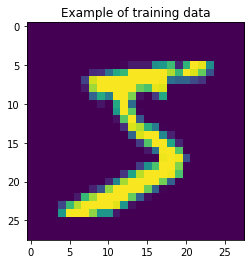

In [50]:
# Load input data and labels
data = torch.load("training.pt")
X = data[0]
Y = data[1]

# Visualize data
dataset = ImageDataset(X,Y) 
img = dataset[0][0]
label = dataset[0][1]
plt.imshow(img.numpy()[0])
plt.title("Example of training data")
print("The label is :")
print(label.numpy())

# Split the dataset in train, val and test data (with sklearn.model_selection.train_test_split function)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# Generate batches of train and val data (with imageDataset class above and torch.utils.data.DataLoader class)
trainDataSet = ImageDataset(X_train,Y_train)
testDataSet = ImageDataset(X_test,Y_test,train=False)
trainLoader = DataLoader(trainDataSet,batch_size=128,shuffle=True)
evalLoader = DataLoader(testDataSet,batch_size=128,shuffle=True)


## CNN model
This is a simple convolutionnal network with two convolutionnal layers and two dense layers.

In [28]:
class MyNetwork(nn.Module):

    def __init__(self):
        super(MyNetwork, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(784, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.bn = nn.BatchNorm2d(32)


    # Forward function of the classification model
    def forward(self, input):
        #x = F.max_pool2d(F.relu(self.conv1(input)),(2,2))
        #x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = input
        x = torch.reshape(x, (x.shape[0],-1))
        x = nn.Dropout(0.2)(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [29]:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    n = 10 # number of classes
    # Model architecture, Loss function & Optimizer
    net = MyNetwork()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    lossTrainList = []
    lossValList = []
    epochs = []

    best_acc = 0.0
    num_epochs = 20
    # Training
    for epoch in range(num_epochs):
        epochs.append(epoch)
        for phase in ['train', 'val']:
            epoch_loss = []
            epoch_acc = 0

            if phase=='train':
                # Model in training mod
                net.train()
                loader = trainLoader
                
            else:
                # Model in evaluation mod
                net.eval()
                loader = evalLoader

            for i, data in enumerate(loader):
                # Load image and class inside a batch 
                imgs = data[0].to(device)
                labels = data[1].to(device)

                # Set the gradient to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # compute or not the gradient
                    # Apply the model & compute the loss
                    preds = net(imgs)
                    loss = criterion(preds, labels)
                    v, i = torch.max(preds,1)

                    epoch_acc += torch.sum(i == labels)
                    epoch_loss.append(loss.item())

                    if phase == 'train':
                        # compute the gradient & update parameters
                        loss.backward()
                        optimizer.step()

            # Display loss
            mean_loss_epoch = np.mean(epoch_loss)
            std_loss_epoch = np.std(epoch_loss)

            
            if phase == 'train':
                lossTrainList.append(mean_loss_epoch)
                print(f'Epoch: {epoch + 1}, Loss_train: {mean_loss_epoch:.4f} (± {std_loss_epoch:.4f})')
            else:           
                lossValList.append(mean_loss_epoch)
                print(f'Epoch: {epoch + 1}, Loss_val: {mean_loss_epoch:.4f} (± {std_loss_epoch:.4f})')

                if epoch_acc< best_acc :
                    # Keep curent model with copy function
                    best_acc = epoch_acc
                    print(best_acc)
                    goodNet = copy.deepcopy(net)

# Save best classification model
torch.save(net.state_dict(), 'net.pt')

Epoch: 1, Loss_train: 1.4803 (± 0.1042)
Epoch: 1, Loss_val: 1.4613 (± 0.0001)
Epoch: 2, Loss_train: 1.4613 (± 0.0001)
Epoch: 2, Loss_val: 1.4612 (± 0.0001)
Epoch: 3, Loss_train: 1.4612 (± 0.0000)
Epoch: 3, Loss_val: 1.4612 (± 0.0000)
Epoch: 4, Loss_train: 1.4612 (± 0.0000)
Epoch: 4, Loss_val: 1.4612 (± 0.0000)


KeyboardInterrupt: 

## Evaluate the model
The model has allready been trained and is stored on net.py. Let's check if it works

In [9]:
# Load classification model with its weights
model = MyNetwork()
model.load_state_dict(torch.load('net.pt'))
model.eval()

# Generate batches of test data 
loader_test = evalLoader

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# Testing
with torch.no_grad(): # no gradient
    for i, data in enumerate(loader_test):
        # Load image and class inside a batch 
        imgs = data[0]
        labels = data[1]

        # Apply the model
        preds = model(imgs)
        v, i = torch.max(preds,1)

        # Append batch prediction results
        predlist=torch.cat([predlist,i.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Display results
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

# accuracy
print(np.mean(class_accuracy))
    

[[29  0  0  0  0  1  0  0  0  0]
 [ 0 30  0  2  1  1  0  0  0  0]
 [ 0  0 32  0  0  5  8  0  2  1]
 [ 0  0  0 42  0  1  5  0  1  0]
 [ 0  0  0  1 38  0  0  1  1  0]
 [ 0  1  0  0  1 29  1  0  1  1]
 [ 0  2  0  1  0  0 34  0  0  2]
 [ 0  1  0  0  0  0  0 37  0  0]
 [ 0  0  2  3  4  0  0  3 43  0]
 [ 1  0  0  0  0  0  1  0  0 43]]
[96.66666667 88.23529412 66.66666667 85.71428571 92.68292683 85.29411765
 87.17948718 97.36842105 78.18181818 95.55555556]
87.35452396110858


# Monte-Carlo Dropout
Let's evaluate the covariance of a measurement of the model with Monte-Carlo dropout 

In [11]:
def monteCarloDropout(img, model, n):
  avg = np.zeros((10,1))
  pred_list = np.zeros((n,10))
  for k in range(n):
    model.train()
    pred = model(img)
    pred_list[k] = pred.detach().numpy()[0]
    avg += np.expand_dims(pred_list[k], axis=1)

  avg = avg/n
  cov = np.zeros((10,10))
  for k in range(n):
    pred = np.expand_dims(pred_list[k], axis=1)
    delta = pred-avg
    mat = np.matmul(delta,delta.transpose())
    cov += mat
  return cov/n

def show_field(field1,field2):

    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1, vmin = _min, vmax = _max)
    ax.autoscale(False)
    ax2 = fig.add_subplot(1, 2, 2)
    #Add the vmin and vmax arguments to set the color scale
    ax2.imshow(field2, vmin = _min, vmax = _max)
    ax2.autoscale(False)
    plt.colorbar(ax2.imshow(field2, vmin = _min, vmax = _max))
    plt.show()

Let's compute the covariance matrix for an image in the training data range

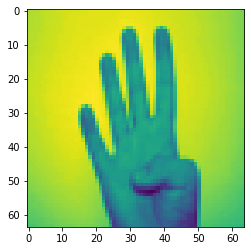

In [12]:
# set the dataset to eval mode
dataset = ImageDataset(X,Y, train=False) 

# select an image in the evaluation se
i = 10
img = torch.unsqueeze(testDataSet[i][0],0)

cov0 = np.abs(monteCarloDropout(img,model,300))
numpyImage = img.numpy()
plt.imshow(numpyImage[0][0])


Now let's compute the matrix for a noisy image

0.0007165195614673515


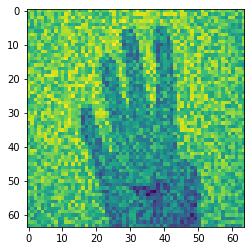

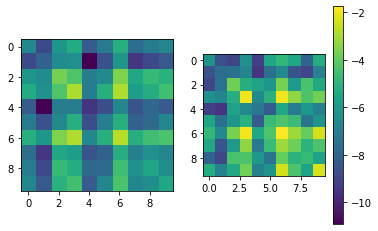

In [16]:
# We generate an unknown image
sigma = 0.5
noise = sigma*np.random.rand(64,64)
# randIm = img[0][0].numpy()[::-1,::-1]
im = img[0][0].numpy() + noise
noisyTensor = torch.unsqueeze(torch.FloatTensor(im),0)
noisyTensor = torch.unsqueeze(noisyTensor,0)

# Let's compute the covariance matrix
plt.imshow(noisyTensor.numpy()[0][0])
cov1 = np.abs(monteCarloDropout(noisyTensor,model,300))
print(np.mean(cov1))

show_field(np.log10(cov0),np.log10(cov1))

Let's try it for a rotated image

0.002241431383982927


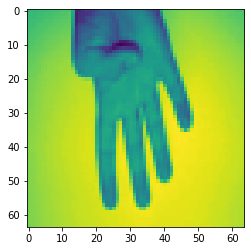

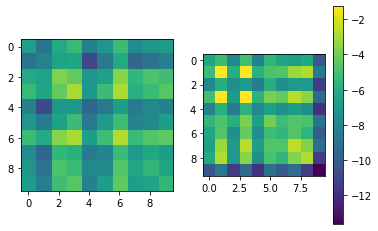

In [23]:
# let's rotate the image
rotatedIm = img[0][0].numpy()[::-1,::-1]
rotatedIm = rotatedIm.copy()
rotatedTensor = torch.unsqueeze(torch.FloatTensor(rotatedIm),0)
rotatedTensor = torch.unsqueeze(rotatedTensor,0)

# Let's compute the covariance matrix
plt.imshow(rotatedTensor.numpy()[0][0])
cov2 = np.abs(monteCarloDropout(rotatedTensor,model,300))
print(np.mean(cov2))

show_field(np.log10(cov0),np.log10(cov2))